In [13]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd

num_group_of_4 = 8  # Number of groups with 4 members
num_group_of_3 = 2  # Number of groups with 3 members
# input_file = 'aip-clustering/authors_list_partial.csv'
input_file = 'aip-clustering/authors_list_mpnet_partial.csv'
# minimization = True
minimization = False
df = pd.read_csv(input_file)

N = df.shape[0]
G = num_group_of_4 + num_group_of_3
assert N == num_group_of_4 * 4 + num_group_of_3 * 3, "The total number of points does not match the total group sizes."

group_sizes = [4]*num_group_of_4 + [3]*num_group_of_3  # List of group sizes
points = range(N)
groups = range(G)

author_names = df['author'].values
coordinates = df[['x_coordinate', 'y_coordinate']].values
x_coords = coordinates[:, 0]
y_coords = coordinates[:, 1]

# Calculate distance matrix
D = np.zeros((N, N))
for i in points:
    for j in points:
        D[i, j] = np.hypot(x_coords[i] - x_coords[j], y_coords[i] - y_coords[j])

# Create model
m = gp.Model("Grouping")

# Set time limit to 10 minutes
m.setParam('TimeLimit', 600) 

# Decision variables x_{i,k}
x = m.addVars(points, groups, vtype=GRB.BINARY, name="x")

# Set objective function
obj = gp.quicksum(D[i, j] * x[i, k] * x[j, k] * 0.5
                  for k in groups for i in points for j in points if i != j)
m.setObjective(obj, GRB.MINIMIZE if minimization else GRB.MAXIMIZE)

# Constraint 1: Each point is assigned to exactly one group
for i in points:
    m.addConstr(gp.quicksum(x[i, k] for k in groups) == 1, name=f"Assign_{i}")

# Constraint 2: Each group has the specified number of points
for k in groups:
    m.addConstr(gp.quicksum(x[i, k] for i in points) == group_sizes[k], name=f"GroupSize_{k}")

# Optimize
m.optimize()

Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i9-13900H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Academic license 2565624 - for non-commercial use only - registered to ur___@g.ecc.u-tokyo.ac.jp
Optimize a model with 21138 rows, 14821 columns and 49970 nonzeros
Model fingerprint: 0x0d56aaeb
Model has 7030 quadratic objective terms
Variable types: 1 continuous, 14820 integer (14820 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-01, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 107.7506831
Presolve removed 21090 rows and 14441 columns
Presolve time: 0.07s
Presolved: 7078 rows, 7410 columns, 21850 nonzeros
Variable types: 0 continuous, 


Group 1:
 Point IDs: [0, 13, 15, 24]
 Names: ['Seiji Shimizu' 'Xing Zhang' 'Kota Sugimoto' 'Yoshiki WATANABE']
 Total distance within group: 15.95336999806113

Group 2:
 Point IDs: [3, 6, 10, 18]
 Names: ['Kyosuke Hatsugai' 'Kazuhito Mori' 'Mika Oki' 'AprilPyoneMaungMaung']
 Total distance within group: 14.885016192442757

Group 3:
 Point IDs: [11, 25, 31, 37]
 Names: ['Norihisa Namura' 'Shimizu Takafumi' 'Tomoki Ono' 'Yuki Ogasawara']
 Total distance within group: 16.266689205091094

Group 4:
 Point IDs: [4, 8, 22, 33]
 Names: ['Ayaka Mito' 'Tatsuya Kubo' 'Alex Orsholits' 'Sato Motoaki']
 Total distance within group: 13.523731717666418

Group 5:
 Point IDs: [14, 17, 34, 36]
 Names: ['Taku Imaizumi' 'Yosuke Kawasaki' 'Noriaki Hashimoto' 'Hamada Rizk']
 Total distance within group: 13.52952485794315

Group 6:
 Point IDs: [23, 26, 27, 35]
 Names: ['Awane Aika' 'Tokio Takada' 'Miyagi Ryota' 'Hiroyuki Hanada']
 Total distance within group: 15.76278691988432

Group 7:
 Point IDs: [1, 12, 2

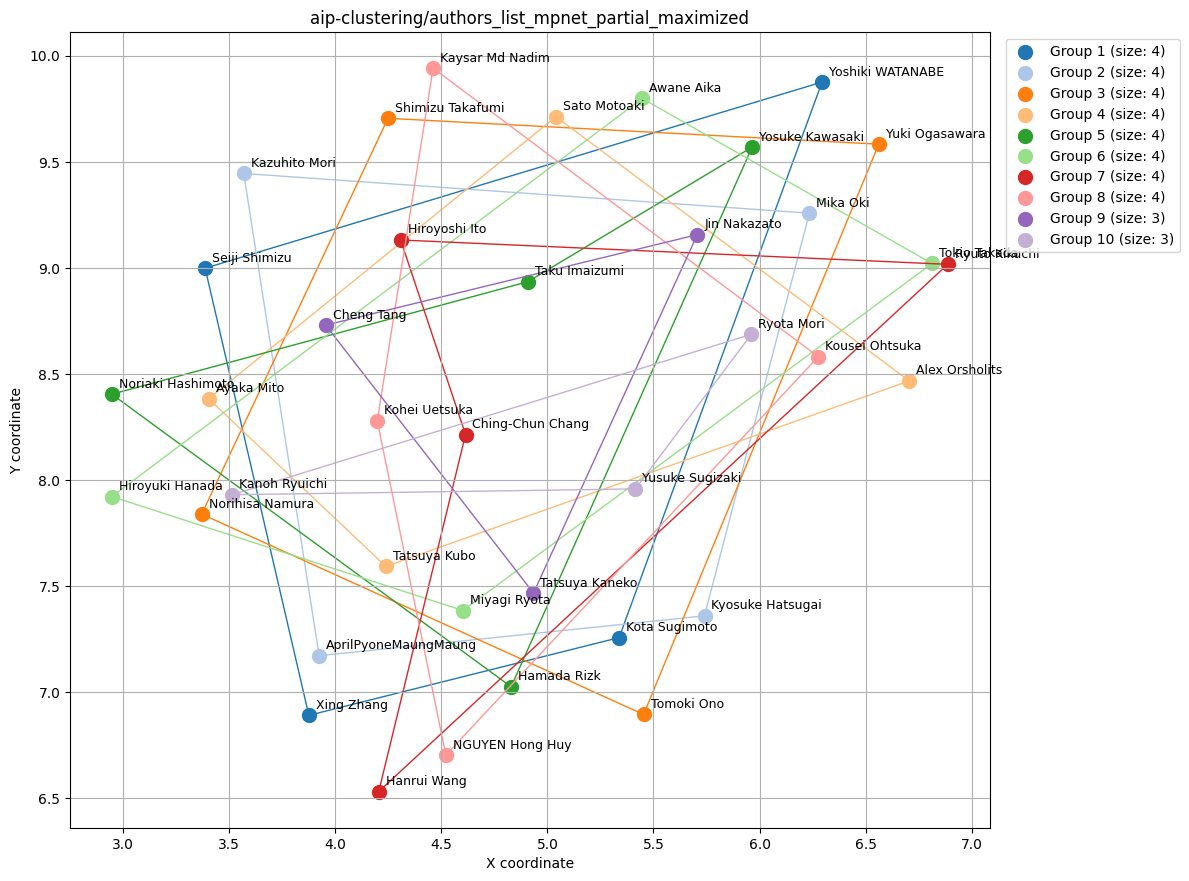

In [12]:
import matplotlib.pyplot as plt

# Set up group_color map
cmap = plt.get_cmap('tab20')  # 20 colors
colors = [cmap(i) for i in range(G)]

# Create figure and axis with equal aspect ratio
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_aspect('equal', 'box')

for k in groups:
    group_points = [i for i in points if x[i, k].X > 0.5]
    group_coords = coordinates[group_points]
    group_names = author_names[group_points]
    group_color = colors[k % len(colors)]

    # Plot group points
    ax.scatter(group_coords[:, 0], group_coords[:, 1], c=[group_color], s=100, label=f'Group {k+1} (size: {group_sizes[k]})')
    # Annotate each point with the author's name
    for i, txt in enumerate(group_names):
        ax.annotate(txt, (group_coords[i, 0], group_coords[i, 1]), fontsize=9, xytext=(5,5), textcoords='offset points')

    if minimization:
        # Calculate centroid of the group
        centroid = np.mean(group_coords, axis=0)
        # Calculate distances from centroid to each point, get max distance
        distances = np.linalg.norm(group_coords - centroid, axis=1)
        radius = np.max(distances)
        # Draw circle around the group
        circle = plt.Circle((centroid[0], centroid[1]), radius, color=group_color, fill=False, linestyle='-')
        ax.add_artist(circle)
        # Plot centroid
        ax.scatter(centroid[0], centroid[1], c=[group_color], marker='x', s=200)
    
    else:
        # Sort points in the group by angle
        center = np.mean(group_coords, axis=0)
        angles = np.arctan2(group_coords[:, 1] - center[1], group_coords[:, 0] - center[0])
        sorted_indices = np.argsort(angles)
        # Plot convex hull around the group
        polygon_coords = group_coords[sorted_indices]
        # Close the polygon using breaking point
        polygon = plt.Polygon(polygon_coords, fill=False, edgecolor=group_color, linestyle='-')
        ax.add_patch(polygon)

    print(f"\nGroup {k+1}:")
    print(f" Point IDs: {group_points}")
    print(f" Names: {group_names}")
    # Calculate total distance within the group
    total_distance = 0
    for i in range(len(group_points)):
        for j in range(i+1, len(group_points)):
            idx_i = group_points[i]
            idx_j = group_points[j]
            total_distance += D[idx_i, idx_j]
    print(f" Total distance within group: {total_distance}")

ax.set_title(f"{input_file.split('.')[0]}_{'minimized' if minimization else 'maximized'}") 
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.grid(True)
# Place legend outside the plot
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{input_file.split('.')[0]}_{'minimized' if minimization else 'maximized'}.png", bbox_inches='tight')
plt.show()